In [ ]:
# RUN THIS BEFORE RUNNING OTHER CODE CELLS #
import numpy as np
import random as rand
import matplotlib.pyplot as plt
import matplotlib.cm as cm

######################################### Dataset ################################################
A1X, A1Y = [[1.0, 0.0, 1.0, 0.0], [1.0, 1.0, 0.0, 0.0]], [[0.0, 1.0, 1.0, 0.0]]

######################################### Class Definitions ################################################
# Neuron Class
class Neuron:

  def __init__(self, ID):

    self.NeuronID = ID  

    self.Bias = 0.0
    self.Input = 0.0
    self.Output = 0.0
    self.SquareError = 0.0

# Weight Class
class Weight:

  def __init__(self, WeightID, PtrStart, PtrEnd, WeightVal = 0.0, InputVal = 0.0):
    
    self.WeightID = WeightID
    self.WeightValue = WeightVal
    self.InputValue = InputVal

    self.PtrStart = PtrStart
    self.PtrEnd = PtrEnd

# Layer Class
class Layer:

  def __init__(self, ID):

    self.LayerID = ID
    self.NeuronIDs = []
    self.WeightIDs = []

  def GetNeuronCount(self):
    
    return len(self.NeuronIDs)

  def GetWeightCount(self):
    
    return len(self.WeightIDs)

# Case Class
class Case:

  def __init__(self, ID, X, Y):

    self.CaseID = ID

    self.X = X
    self.Y = Y

    self.ActualOutput = 0.0
    self.Error = 0.0

# Activation Class
class Act:

  def Step(X, Derivative = False, Threshold = 0.5): 
    
    if Derivative: return 0.0
    elif X >= Threshold: return 1.0
    else: return 0.0

  def Sigmoid(X, Derivative = False): 
        
    if Derivative: return  X * (1.0 - X)
    else: return 1.0 / (1.0 + np.exp(-X))

  def Sign(X, Derivative = False): 
    
    if Derivative: return 0.0
    elif X > 0.0: return 1.0
    elif X < 0.0: return -1.0
    else: return 0.0

# Model Class
class Model:
 
    # Init Model vairables
    def __init__(self):

        # Training Data
        self.Case = []
        self.InputCount = 0
        self.OutputCount = 0

        self.CountNeuronID = -1
        self.CountWeightID = -1
        self.CountLayerID = -1

        # Neural Network Attributes
        self.EpochMax = 0
        self.LearnRate = 0.0
        self.Activate = None
        
        # Neural Network Objects
        self.Layer = [] # index 0 = input layer, index -1 = output layer
        self.Neuron = []
        self.Weight = []

        self.EpochSumError = []
        self.Accuracy = []

    # ID System #
    def CreateLayerID(self):
        
        self.CountLayerID += 1
        return self.CountLayerID
    def CreateNeuronID(self):
    
        self.CountNeuronID += 1
        return self.CountNeuronID
    def CreateWeightID(self):
        
        self.CountWeightID += 1
        return self.CountWeightID
    # End ID System #
    
    def GetWeightValue(self, PtrStart, PtrEnd):
        
        for w in self.Weight:
            if w.PtrStart == PtrStart and w.PtrEnd == PtrEnd: return w.WeightValue

        return 0.0
    
  # Training Data
    def InitDataSet(self, X, Y):
        
        # We count the number of nested lists, not the number of elements
        self.InputCount = sum(isinstance(i, list) for i in X)
        self.OutputCount = sum(isinstance(i, list) for i in Y)

        # Generate Cases from training data
        if self.InputCount == 2 and self.OutputCount == 1:

            for c in range(0, len(X[0]),1):
                self.Case.append(Case(c, [ X[0][c], X[1][c] ], Y[0][c]))

        else: assert False, "Invalid Training Data - Dataset not supported"

  # Neural Network
    def InitNeuralNet(self):
        
        # Create Layers
        for l in range(0,3,1):
        
            self.Layer.append(Layer(self.CreateLayerID()))

            # Create Input, hidden and output neurons
            for n in range(0, self.InputCount if l != 2 else self.OutputCount, 1):
                self.Neuron.append(Neuron(self.CreateNeuronID()))
                self.Layer[-1].NeuronIDs.append(self.Neuron[-1].NeuronID)

        # Generate Weights 
        for l in self.Layer[1::]:
            
            # Set random weights and biases for layer
            initWeight = rand.uniform(0.0,1.0)
            initBias = rand.uniform(-.5,.5)

            for n in l.NeuronIDs:
                
                self.Neuron[n].Bias = initBias

                for nPrior in self.Layer[l.LayerID - 1].NeuronIDs: # Connect to each neuron in the previous layer
                    
                    self.Weight.append(Weight(self.CreateWeightID(), nPrior, n, initWeight))
                    self.Layer[l.LayerID].WeightIDs.append(self.Weight[-1].WeightID)

  # Train Model
    def TrainModel(self, Activate, LearnRate = 0.1, EpochMax = 1000):
    
        # Save neural network attributes
        self.Activate = Activate
        self.LearnRate = LearnRate
        self.EpochMax = EpochMax

        for e in range(0, EpochMax):
            
            # Train on each case
            for c in self.Case:
                
                # Feed Data to Input Layer
                for n in self.Layer[0].NeuronIDs:

                    # Set Input Neuron Output to Case Input
                    self.Neuron[n].Input = c.X[n]
                    self.Neuron[n].Output = self.Neuron[n].Input

                    # Set Weight Input Values. This propogates the output through the network
                    for w in self.Layer[1].WeightIDs:

                        if self.Weight[w].PtrStart == self.Neuron[n].NeuronID:
                            self.Weight[w].InputValue = self.Neuron[n].Output

                # Forward Propogation
                for l in self.Layer[1::]: # Skip Input Layer

                    for n in l.NeuronIDs:

                        # Calculate Input - Start From Bias and add weighted inputs
                        self.Neuron[n].Input = self.Neuron[n].Bias
                        
                        for w in l.WeightIDs:
                            
                            if self.Weight[w].PtrEnd == self.Neuron[n].NeuronID: 
                                self.Neuron[n].Input += self.Weight[w].InputValue * self.Weight[w].WeightValue
            
                        # Calculate Output
                        self.Neuron[n].Output = Activate(self.Neuron[n].Input)

                        # Update Weight Input from neuron output - This propogates to the next layer
                        if l.LayerID != self.Layer[-1].LayerID:
                            
                            for w in self.Layer[l.LayerID + 1].WeightIDs:
                                
                                if self.Weight[w].PtrStart == self.Neuron[n].NeuronID: 
                                    self.Weight[w].InputValue = self.Neuron[n].Output

                # Error Calculation. Index -1 is the output neuron
                error = c.Y - self.Neuron[-1].Output
                delta = Activate(self.Neuron[-1].Output, Derivative = True) * error

                # Update Case
                c.ActualOutput = self.Neuron[-1].Output
                c.Error = abs(error)

                # Back Propogation
                for n in reversed(self.Neuron[self.InputCount::]): # Skip Input layer, Start from Output reversed
                
                    # We check if the neuron is the output neuron. If it is, we use the delta calculated above
                    outputDeriv = Activate(n.Output, Derivative = True) * self.GetWeightValue(n.NeuronID, self.Neuron[-1].NeuronID)
                    localDelta = outputDeriv * delta if (n.NeuronID != self.Neuron[-1].NeuronID) else delta
                    
                    # Update Weights
                    for w in reversed(self.Weight):

                        if w.PtrEnd == n.NeuronID: 
                         w.WeightValue += LearnRate * w.InputValue * localDelta

                    # Update Bias
                    n.Bias += LearnRate * localDelta

                # Accumulate Squared Error
                for n in self.Neuron[self.InputCount::]:

                    # Calculate Input - Start From Bias and add weighted inputs
                    sqX = n.Bias
                
                    for w in self.Weight:

                        if w.PtrEnd == n.NeuronID: 
                            sqX += w.InputValue * w.WeightValue
                
                    # Calculate Output
                    n.SquareError = Activate(sqX)
                
                # Error Calculation. Index -1 is the output neuron
                self.EpochSumError.append((c.Y - self.Neuron[-1].SquareError) ** 2)

                # Repeat training until epoch sum error is less than 0.001
                if(self.EpochSumError[-1] < 0.001): break

            # Calculate Accuracy
            accuracy = 0.0
            for c in self.Case:
                accuracy += 1 - c.Error
            self.Accuracy.append(accuracy / len(self.Case))

In [ ]:
# Testing Learning Rates

LearnRate = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.25, 1.5, 1.75, 2.0, 5.0, 10.0] # 

colors = cm.rainbow(np.linspace(0, 1, len(LearnRate)))

plt.figure(figsize=(15,5))

for lr, color in zip(LearnRate, colors):
    # Initialise Model
    model = Model()
    
    # # Set training data [[x1], [x2]], [[y1]]
    model.InitDataSet(A1X, A1Y)

    # # Init Nerual Newtwork 
    model.InitNeuralNet()

    #model.Weight[0].WeightValue = 0.5
    #model.Weight[1].WeightValue = 0.4
    #model.Weight[2].WeightValue = 0.9
    #model.Weight[3].WeightValue = 1.0
    #model.Weight[4].WeightValue = -1.2
    #model.Weight[5].WeightValue = 1.1

    #model.Neuron[2].Bias = 0.8
    #model.Neuron[3].Bias = -0.1
    #model.Neuron[4].Bias = 0.3
    # # Train model
    model.TrainModel(Activate= Act.Sigmoid, LearnRate= lr, EpochMax= 20000)
    
    plt.plot(range(1, len(model.Accuracy) + 1), model.Accuracy, color = color, linewidth = 0.5,label="LearnRate: {}".format(lr))

plt.title("Learn Rate effects - Accuracy vs epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(loc='best')
plt.show()



In [ ]:
# Testing Activation Functions

activation = [Act.Sigmoid, Act.Step, Act.Sign] 

colors = cm.rainbow(np.linspace(0, 1, len(LearnRate)))

plt.figure(figsize=(15,5))

for act, color in zip(activation, colors):
    # Initialise Model
    model = Model()
    
    # # Set training data [[x1], [x2]], [[y1]]
    model.InitDataSet(A1X, A1Y)

    # # Init Nerual Newtwork 
    model.InitNeuralNet()

    model.Weight[0].WeightValue = 0.5
    model.Weight[1].WeightValue = 0.4
    model.Weight[2].WeightValue = 0.9
    model.Weight[3].WeightValue = 1.0
    model.Weight[4].WeightValue = -1.2
    model.Weight[5].WeightValue = 1.1

    model.Neuron[2].Bias = 0.8
    model.Neuron[3].Bias = -0.1
    model.Neuron[4].Bias = 0.3
    # # Train model
    model.TrainModel(Activate= act, LearnRate= 0.3, EpochMax= 20000)
    
    plt.plot(range(1, len(model.Accuracy) + 1), model.Accuracy, color = color, linewidth = 0.5,label=model.Activate.__name__)

plt.title("Activation Functions - Accuracy vs epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(loc='best')
plt.show()

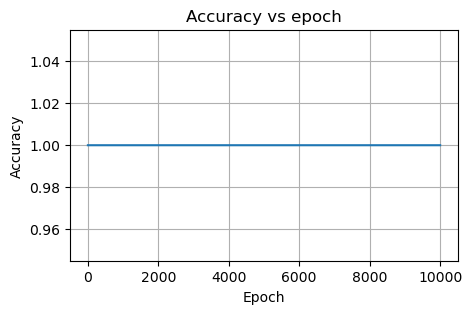

In [22]:
# Optimal Model based on Research

# Using the step function doesn't reveal the whole picture. 
# The sigmoid function is more suitable for this dataset when testing

# Initialise Model
model = Model()

# # Set training data [[x1], [x2]], [[y1]]
model.InitDataSet(A1X, A1Y)

# # Init Nerual Newtwork 
model.InitNeuralNet()

# # Train model
model.TrainModel(Activate= Act.Step, LearnRate= 0.3, EpochMax= 10000)

plt.figure(figsize=(5,3))
plt.plot(range(1, len(model.Accuracy) + 1), model.Accuracy)
plt.title("Accuracy vs epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()